In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import ast
import glob
import requests
tqdm.pandas()

In [2]:

from logging import getLogger, StreamHandler, DEBUG, INFO, FileHandler, Formatter
logger = getLogger(__name__)
sthandler = StreamHandler()
sthandler.setLevel(DEBUG)

filehandler = FileHandler("logger.log")
filehandler.setLevel(DEBUG)

formatter = Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
filehandler.setFormatter(formatter)
sthandler.setFormatter(formatter)

logger.addHandler(sthandler)
logger.addHandler(filehandler)
logger.setLevel(DEBUG)
logger.propagate = False

logger.debug('hello')  

2023-04-05 05:07:26,330:18:DEBUG:hello


In [3]:
with open('df_fake_claim.pickle', mode='rb') as f:
    df_fake_claim = pickle.load(f)

In [4]:
df_fake_claim.shape

(10190, 33)

In [5]:
with open('df_fake_url.pickle', mode='rb') as f:
    df_fake_url = pickle.load(f)

In [6]:
df_fake_url.shape

(333470, 32)

In [7]:
fake_ids = list(set(list(df_fake_url.index) + list(df_fake_claim.index)))

In [8]:
len(fake_ids)

343549

## reply

In [11]:
with open('df_reply.pickle', mode='rb') as f:
    df_reply = pickle.load(f)

In [12]:
df_reply.shape

(1190643, 25)

In [13]:
df_reply["type_of_fake"].value_counts()

claim_based     1011179
domain_based     179464
Name: type_of_fake, dtype: int64

In [14]:
df_reply["pred"].value_counts()

0    650630
1    540013
Name: pred, dtype: int64

In [15]:
df_reply.groupby("type_of_fake")["pred"].value_counts().unstack()

pred,0,1
type_of_fake,,
claim_based,529641,481538
domain_based,120989,58475


## quote

In [16]:
with open('df_quote.pickle', mode='rb') as f:
    df_quote = pickle.load(f)

In [18]:
df_quote.shape

(527007, 25)

In [17]:
df_quote["type_of_fake"].value_counts()

claim_based     470349
domain_based     56658
Name: type_of_fake, dtype: int64

In [19]:
df_quote.groupby("type_of_fake")["pred"].value_counts().unstack()

pred,0,1
type_of_fake,,
claim_based,352572,117777
domain_based,47214,9444


## stats

In [23]:
tmp_map = df_quote["to_quote_id"].value_counts()
tmp_map.index = tmp_map.index.astype(str)
tmp_map = tmp_map.to_dict()
df_fake_url["quoted_count"] = df_fake_url.index.map(tmp_map)
df_fake_url["quoted_count"] = df_fake_url["quoted_count"].fillna(0)
df_fake_claim["quoted_count"] = df_fake_claim.index.map(tmp_map)
df_fake_claim["quoted_count"] = df_fake_claim["quoted_count"].fillna(0)

In [24]:
df_fake_claim["quoted_count"].describe()

count    10190.000000
mean        46.162709
std        556.827610
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      28669.000000
Name: quoted_count, dtype: float64

In [26]:
tmp_map = df_quote[df_quote["pred"]==1]["to_quote_id"].value_counts()
tmp_map.index = tmp_map.index.astype(str)
tmp_map = tmp_map.to_dict()
df_fake_url["quoted_count_debunk"] = df_fake_url.index.map(tmp_map)
df_fake_url["quoted_count_debunk"] = df_fake_url["quoted_count_debunk"].fillna(0)

In [27]:
df_fake_url["quoted_count_debunk"].describe()

count    333470.000000
mean          0.028320
std           1.954931
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1020.000000
Name: quoted_count_debunk, dtype: float64

In [28]:
df_fake_claim["quoted_count_debunk"] = df_fake_claim.index.map(tmp_map)
df_fake_claim["quoted_count_debunk"] = df_fake_claim["quoted_count_debunk"].fillna(0)

In [29]:
df_fake_claim["quoted_count_debunk"].describe()

count    10190.000000
mean        11.558292
std        163.286969
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9349.000000
Name: quoted_count_debunk, dtype: float64

In [30]:
tmp_map = df_reply["to_reply_id"].value_counts()
tmp_map.index = tmp_map.index.astype(str)
tmp_map = tmp_map.to_dict()
df_fake_url["replied_count"] = df_fake_url.index.map(tmp_map)
df_fake_url["replied_count"] = df_fake_url["replied_count"].fillna(0)

In [31]:
df_fake_url["replied_count"].describe()

count    333470.000000
mean          0.538171
std          27.984044
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       14648.000000
Name: replied_count, dtype: float64

In [32]:
df_fake_claim["replied_count"] = df_fake_claim.index.map(tmp_map)
df_fake_claim["replied_count"] = df_fake_claim["replied_count"].fillna(0)

In [33]:
df_fake_claim["replied_count"].describe()

count    10190.000000
mean        99.237880
std       1006.568247
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      37428.000000
Name: replied_count, dtype: float64

In [34]:
tmp_map = df_reply[df_reply["pred"]==1]["to_reply_id"].value_counts()
tmp_map.index = tmp_map.index.astype(str)
tmp_map = tmp_map.to_dict()
df_fake_url["replied_count_debunk"] = df_fake_url.index.map(tmp_map)
df_fake_url["replied_count_debunk"] = df_fake_url["replied_count_debunk"].fillna(0)

In [35]:
df_fake_url["replied_count_debunk"].describe()

count    333470.000000
mean          0.175353
std          22.454537
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       12598.000000
Name: replied_count_debunk, dtype: float64

In [36]:
df_fake_claim["replied_count_debunk"] = df_fake_claim.index.map(tmp_map)
df_fake_claim["replied_count_debunk"] = df_fake_claim["replied_count_debunk"].fillna(0)

In [37]:
df_fake_claim["replied_count_debunk"].describe()

count    10190.000000
mean        47.257115
std        570.785136
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      25544.000000
Name: replied_count_debunk, dtype: float64

## zipf

In [39]:
from scipy.stats import zipf, kstest

claim_based
to_reply_id
all


  0%|          | 0/1000 [00:00<?, ?it/s]

1.306402902902903
KstestResult(statistic=0.9995454545454545, pvalue=0.0)
debunking


  0%|          | 0/1000 [00:00<?, ?it/s]

1.3154118118118119
KstestResult(statistic=0.9993425378040762, pvalue=0.0)
claim_based
to_quote_id
all


  0%|          | 0/1000 [00:00<?, ?it/s]

1.306402902902903
KstestResult(statistic=0.9994694960212201, pvalue=0.0)
debunking


  0%|          | 0/1000 [00:00<?, ?it/s]

1.3514474474474474
KstestResult(statistic=0.9991554054054054, pvalue=0.0)
domain_based
to_reply_id
all


  0%|          | 0/1000 [00:00<?, ?it/s]

1.9370265265265265
KstestResult(statistic=0.9999669923422234, pvalue=0.0)
debunking


  0%|          | 0/1000 [00:00<?, ?it/s]

2.099186886886887
KstestResult(statistic=0.9999047981721249, pvalue=0.0)
domain_based
to_quote_id
all


  0%|          | 0/1000 [00:00<?, ?it/s]

2.0901779779779783
KstestResult(statistic=0.9999417453104975, pvalue=0.0)
debunking


  0%|          | 0/1000 [00:00<?, ?it/s]

2.3694541541541545
KstestResult(statistic=0.99970836978711, pvalue=0.0)


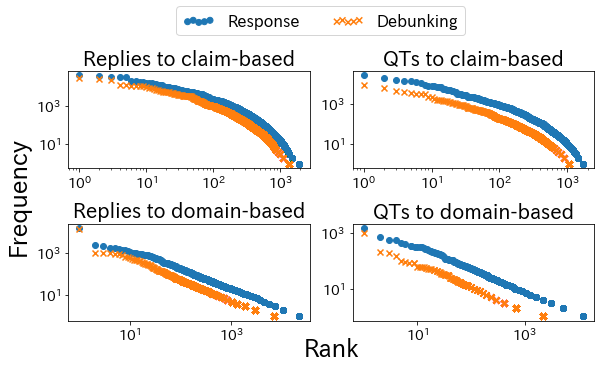

In [40]:
#plt.figure(figsize=(4,2))
fig, axs = plt.subplots(2, 2, figsize=(9,5))


axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xscale('log')

for i, type_ in enumerate(["claim_based", "domain_based"]):
    for j, df_ in enumerate([df_reply, df_quote]):
        if j == 0:
            col = "to_reply_id"
        else:
            col = "to_quote_id"
        a = df_[df_["type_of_fake"] == type_][col].value_counts()
        b = df_[(df_["pred"]==1)&(df_["type_of_fake"] == type_)][col].value_counts()
        axs[i, j].scatter(x=a.rank(ascending=False).values, y=a.values, label="Response")
        axs[i, j].scatter(x=b.rank(ascending=False).values, y=b.values, marker="x", label="Debunking")

#         axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), fontsize=14)

        print(type_)
        print(col)
        print("all")
        tmp_list = []
        for ii in tqdm(np.linspace(1.0001, 10.0, 1000)):
            x = np.log(zipf.pmf(a.values, a = ii)).mean()
            #print(i/100, x)
            tmp_list.append((ii, x))

        max_ = pd.DataFrame(tmp_list).sort_values(1).iloc[-1, 0]
        print(max_)
        print(kstest(a.values/a.max(), zipf(a=max_).cdf))
        
        print("debunking")
        tmp_list = []
        for ii in tqdm(np.linspace(1.0001, 10.0, 1000)):
            x = np.log(zipf.pmf(b.values, a = ii)).mean()
            #print(i/100, x)
            tmp_list.append((ii, x))

        max_ = pd.DataFrame(tmp_list).sort_values(1).iloc[-1, 0]
        print(max_)
        print(kstest(b.values/b.max(), zipf(a=max_).cdf))


        axs[i, j].tick_params(axis='both', labelsize=14)
        if i == 0:
            if j == 0:
                axs[i, j].set_title("Replies to claim-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to claim-based", fontsize=20)
        else:
            if j == 0:
                axs[i, j].set_title("Replies to domain-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to domain-based", fontsize=20)

#ax.legend(fontsize=14)

# plt.xticks(fontsize=16)#, rotation=45)
# plt.yticks(fontsize=16)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", size=24, labelpad=15)
plt.xlabel("Rank", size=24, labelpad=0)
fig.tight_layout()
handles, labels = axs[i, j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol= 2, bbox_to_anchor=(0.55, 1.1), fontsize=16, scatterpoints=5)

# #plt.show()
# plt.savefig("figures/freq_rank_all.pdf", format="pdf", dpi=300, bbox_inches='tight')

plt.show()

In [41]:
print(kstest(a.values/a.max(), zipf(a=max_).cdf))

KstestResult(statistic=0.9999417453104975, pvalue=0.0)


In [42]:
from scipy.stats import kstest, zipf, norm, ks_2samp

In [43]:
print(kstest(a.values, zipf(a=5.5).cdf))

KstestResult(statistic=0.9754150728083949, pvalue=0.0)


## Others vs debunking

In [44]:
df_fake_claim["replied_count_other"] = df_fake_claim["replied_count"] - df_fake_claim["replied_count_debunk"]
df_fake_claim["quoted_count_other"] = df_fake_claim["quoted_count"] - df_fake_claim["quoted_count_debunk"]
df_fake_url["replied_count_other"] = df_fake_url["replied_count"] - df_fake_url["replied_count_debunk"]
df_fake_url["quoted_count_other"] = df_fake_url["quoted_count"] - df_fake_url["quoted_count_debunk"]

In [45]:
import matplotlib.cm as cm
import matplotlib as mpl

In [46]:
from scipy.stats import pearsonr

replied
(0.5267153014651282, 0.0)
(0.16790550764119033, 1.9364610020873198e-15)
quoted
(0.48641029105946876, 0.0)
(0.13792507964162, 1.716400500743439e-09)
replied
(0.5857374282896383, 0.0)
(0.027135337940917655, 2.3149752314109943e-06)
quoted
(0.5428580800562003, 0.0)
(0.08391244402010689, 3.31695630403883e-28)


<ipython-input-48-7cfef949d011>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


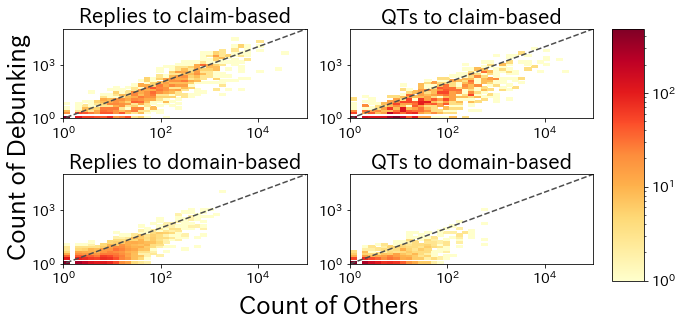

In [48]:
#plt.figure(figsize=(4,2))
fig, axs = plt.subplots(2, 2, figsize=(9,5))


axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xscale('log')


xbins = 10**np.linspace(0, 5, 40)
ybins = 10**np.linspace(0, 5, 40)


for i, df_ in enumerate([df_fake_claim, df_fake_url]):
    for j, type_ in enumerate(["replied", "quoted"]):
        counts, _, _ = np.histogram2d(df_["%s_count_other"%type_], df_["%s_count_debunk"%type_], bins=(xbins, ybins))
        #counts, _, _ = np.histogram2d(df_["%s_count_debunk"%type_], df_["%s_count_other"%type_], bins=(xbins, ybins))
        #counts, _, _ = np.histogram2d(df_["%s_count_debunk"%type_], df_["%s_count"%type_], bins=(xbins, ybins))
        im = axs[i,j].pcolormesh(xbins, ybins, counts.T, cmap="YlOrRd", norm=mpl.colors.LogNorm())
        
        print(type_)
        print(pearsonr(df_["%s_count_debunk"%type_], df_["%s_count_other"%type_]))
#         print(np.corrcoef(df_["%s_count_debunk"%type_], df_["%s_count"%type_]))
        #print(np.corrcoef(df_["%s_count_debunk"%type_], df_["%s_count_debunk"%type_]/df_["%s_count"%type_]))
        tmp_index = df_[df_["%s_count"%type_]!=0].index
#         print(np.corrcoef(
#             df_.loc[tmp_index, "%s_count_debunk"%type_], 
#             #df_.loc[tmp_index, "%s_count_debunk"%type_] / df_.loc[tmp_index, "%s_count"%type_] 
#             df_.loc[tmp_index, "%s_count_other"%type_] 
#         ))
#         print(np.corrcoef(
#             df_.loc[tmp_index, "%s_count_debunk"%type_], 
#             #df_.loc[tmp_index, "%s_count_debunk"%type_] / df_.loc[tmp_index, "%s_count"%type_] 
#             df_.loc[tmp_index, "%s_count"%type_] 
#         ))
        print(pearsonr(
            df_.loc[tmp_index, "%s_count_debunk"%type_], 
            df_.loc[tmp_index, "%s_count_debunk"%type_] / df_.loc[tmp_index, "%s_count"%type_] 
            #df_.loc[tmp_index, "%s_count"%type_] 
        ))
        print("==="*10)
#         axs[i, j].scatter(df_fake_claim["%s_count_debunk"%type_], df_fake_claim["%s_count_other"%type_], alpha=0.2)
#         axs[i, j].set_xscale("log")
#         axs[i, j].set_yscale("log")
#         axs[i, j].set_xlim([1/2,10**5])
#         axs[i, j].set_ylim([1/2,10**5])      
        
        axs[i, j].plot([0, 10**5], [0, 10**5], ls="--", c=".3")

        axs[i, j].tick_params(axis='both', labelsize=14)
        if i == 0:
            if j == 0:
                axs[i, j].set_title("Replies to claim-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to claim-based", fontsize=20)
        else:
            if j == 0:
                axs[i, j].set_title("Replies to domain-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to domain-based", fontsize=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.2, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Count of Others", size=24, labelpad=15)
plt.ylabel("Count of Debunking", size=24, labelpad=10)
fig.tight_layout()
# handles, labels = axs[i, j].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol= 2, bbox_to_anchor=(0.55, 1.1), fontsize=16, scatterpoints=5)

# #plt.show()
# plt.savefig("figures/debunk_vs_others2.pdf", format="pdf", dpi=300, bbox_inches='tight')


plt.show()

replied
[[1.        0.5267153]
 [0.5267153 1.       ]]
[[1.       0.871227]
 [0.871227 1.      ]]
replied
[[1.         0.58573743]
 [0.58573743 1.        ]]
[[1.        0.9720557]
 [0.9720557 1.       ]]
quoted
[[1.         0.48641029]
 [0.48641029 1.        ]]
[[1.         0.69403833]
 [0.69403833 1.        ]]
quoted
[[1.         0.54285808]
 [0.54285808 1.        ]]
[[1.         0.82424499]
 [0.82424499 1.        ]]


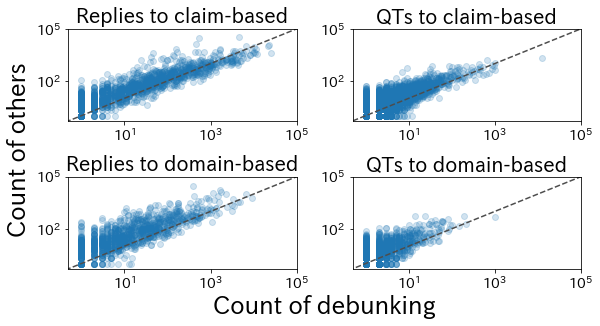

In [49]:
#plt.figure(figsize=(4,2))
fig, axs = plt.subplots(2, 2, figsize=(9,5))


axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xscale('log')


xbins = 10**np.linspace(0, 5, 40)
ybins = 10**np.linspace(0, 5, 40)


for i, type_ in enumerate(["replied", "quoted"]):
    for j, df_ in enumerate([df_fake_claim, df_fake_url]):
        if i == 0:
            col = "to_reply_id"
        else:
            col = "to_quote_id"
        #counts, _, _ = np.histogram2d(df_fake_claim["%s_count_debunk"%type_], df_fake_claim["%s_count_other"%type_], bins=(xbins, ybins))
        #im = axs[i,j].pcolormesh(xbins, ybins, counts.T, cmap="YlOrRd", norm=mpl.colors.LogNorm())
        
        print(type_)
        print(np.corrcoef(df_["%s_count_debunk"%type_], df_["%s_count_other"%type_]))
        print(np.corrcoef(df_["%s_count_debunk"%type_], df_["%s_count"%type_]))
        
        axs[i, j].scatter(df_["%s_count_debunk"%type_], df_["%s_count_other"%type_], alpha=0.2)
        axs[i, j].set_xscale("log")
        axs[i, j].set_yscale("log")
        axs[i, j].set_xlim([1/2,10**5])
        axs[i, j].set_ylim([1/2,10**5])      
        
        axs[i, j].plot([0, 10**5], [0, 10**5], ls="--", c=".3")

        axs[i, j].tick_params(axis='both', labelsize=14)
        if i == 0:
            if j == 0:
                axs[i, j].set_title("Replies to claim-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to claim-based", fontsize=20)
        else:
            if j == 0:
                axs[i, j].set_title("Replies to domain-based", fontsize=20)
            else:
                axs[i, j].set_title("QTs to domain-based", fontsize=20)


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1.0, 0.2, 0.05, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(14)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Count of others", size=24, labelpad=15)
plt.xlabel("Count of debunking", size=24, labelpad=10)
fig.tight_layout()
# handles, labels = axs[i, j].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol= 2, bbox_to_anchor=(0.55, 1.1), fontsize=16, scatterpoints=5)

# #plt.show()
# plt.savefig("figures/debunk_vs_others.pdf", format="pdf", dpi=300, bbox_inches='tight')


plt.show()

## time series

In [50]:
df_fake_claim["created_at"] = df_fake_claim["created_at"].progress_apply(lambda x: pd.Timestamp(x))
df_fake_url["created_at"] = df_fake_url["created_at"].progress_apply(lambda x: pd.Timestamp(x)).dt.tz_localize("Asia/Tokyo").dt.tz_convert("UTC")
df_reply["created_at"] = df_reply["created_at"].progress_apply(lambda x: pd.Timestamp(x))
df_quote["created_at"] = df_quote["created_at"].progress_apply(lambda x: pd.Timestamp(x))

  0%|          | 0/10190 [00:00<?, ?it/s]

  0%|          | 0/333470 [00:00<?, ?it/s]

  0%|          | 0/1190643 [00:00<?, ?it/s]

  0%|          | 0/527007 [00:00<?, ?it/s]

In [51]:
dict_id_time = df_fake_claim["created_at"].to_dict()
dict_id_time_url = df_fake_url["created_at"].to_dict()
dict_id_time.update(dict_id_time_url)

In [52]:
df_reply["created_at_original_tweet"] = df_reply["to_reply_id"].map(dict_id_time)
df_quote["created_at_original_tweet"] = df_quote["to_quote_id"].map(dict_id_time)

In [53]:
df_reply["interval"] = df_reply["created_at"] - df_reply["created_at_original_tweet"]
df_quote["interval"] = df_quote["created_at"] - df_quote["created_at_original_tweet"]

In [54]:
df_reply["interval"] = df_reply["interval"].progress_apply(lambda x: x.seconds)
df_quote["interval"] = df_quote["interval"].progress_apply(lambda x: x.seconds)

  0%|          | 0/1190643 [00:00<?, ?it/s]

  0%|          | 0/527007 [00:00<?, ?it/s]

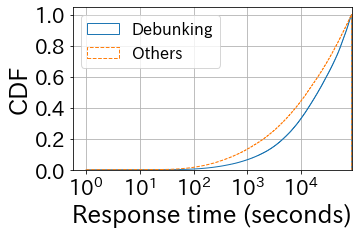

In [55]:
x = df_reply[df_reply["pred"] == 1]["interval"] + 1
y = df_reply[df_reply["pred"] == 0]["interval"] + 1
x = x[x.notnull()]
y = y[y.notnull()]

fig, ax = plt.subplots(figsize=(5,3))
hist, bins = np.histogram(x, bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

n, bins, patches = ax.hist(
    x, cumulative=1, histtype='step', bins=logbins, color='tab:blue', density=True, label="Debunking")

hist, bins = np.histogram(y, bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
n, bins, patches = ax.hist(
    y, cumulative=1, histtype='step', bins=logbins, color='tab:orange', linestyle="dashed", density=True, label="Others")

plt.grid()

ax.set_xscale('log')
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
ax.set_xlabel("Response time (seconds)", fontsize= 24)
#ax.



plt.legend(fontsize=16,  loc='upper left')
# legend(handles, labels, loc='upper center', ncol= 2, bbox_to_anchor=(0.55, 1.1), fontsize=16, scatterpoints=5)

# plt.legend(fontsize=14)
#ax2.legend(fontsize=14)
ax.set_ylabel("CDF",  fontsize= 24)
ax.set_xticks([1, 10, 100, 1000, 10000, 100000])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# ax.legend(ax.get_lines(),\
#         ["a", b""], fontsize=14)#, bbox_to_anchor=(1.5, 0.5))
#ax.set_yscale('log')

ax.set_xlim((ax.get_xlim()[0], np.min([x.max(), y.max()])))

# plt.savefig("figures/response_time_reply.pdf",
#             format="pdf",
#             bbox_inches='tight', 
#            dpi=300)

plt.show()

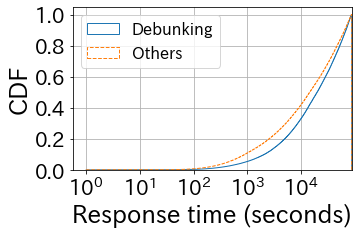

In [56]:
x = df_quote[df_quote["pred"] == 1]["interval"] + 1
y = df_quote[df_quote["pred"] == 0]["interval"] + 1
x = x[x.notnull()]
y = y[y.notnull()]

fig, ax = plt.subplots(figsize=(5,3))
hist, bins = np.histogram(x, bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

n, bins, patches = ax.hist(
    x, cumulative=1, histtype='step', bins=logbins, color='tab:blue', density=True, label="Debunking")

hist, bins = np.histogram(y, bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
n, bins, patches = ax.hist(
    y, cumulative=1, histtype='step', bins=logbins, color='tab:orange', linestyle="dashed", density=True, label="Others")

plt.grid()

ax.set_xscale('log')
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
ax.set_xlabel("Response time (seconds)", fontsize= 24)
#ax.
plt.legend(fontsize=16,  loc='upper left')
# legend(handles, labels, loc='upper center', ncol= 2, bbox_to_anchor=(0.55, 1.1), fontsize=16, scatterpoints=5)

# plt.legend(fontsize=14)
#ax2.legend(fontsize=14)
ax.set_ylabel("CDF",  fontsize= 24)
ax.set_xticks([1, 10, 100, 1000, 10000, 100000])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# ax.legend(ax.get_lines(),\
#         ["a", b""], fontsize=14)#, bbox_to_anchor=(1.5, 0.5))
#ax.set_yscale('log')


ax.set_xlim((ax.get_xlim()[0], np.min([x.max(), y.max()])))

# plt.savefig("figures/response_time_quote.pdf",
#             format="pdf",
#             bbox_inches='tight', 
#            dpi=300)



plt.show()

In [57]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(df_reply[df_reply["pred"] == 1]["interval"], df_reply[df_reply["pred"] == 0]["interval"])
U1, p

(147904213730.5, 0.0)

In [58]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(df_quote[df_quote["pred"] == 1]["interval"], df_quote[df_quote["pred"] == 0]["interval"])
U1, p

(22453127364.5, 0.0)